In [29]:
#hello everyone, in this tutorial let us look at generating art using AI
#There are mainly 6 steps in Neural Style Transfer
#STEP 1: Choose the Content and Style Image.

#STEP 2: Preprocess the image.

#STEP 3: Generate a random image of the same size as content and style image.

#STEP 4: Design the model.

#STEP 5: Calculate Loss.

#STEP 6: Optimize unless converged.

In [2]:
#TensorFlow is an open source platform for machine learning. It is widely used for many ML solutions involving recommendation
#systems and  neural networks.
import tensorflow as tf
#Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.
import matplotlib.pyplot as plt
#numpy is used for scientific computing in python that helps mainly in creating arrays.
import numpy as np
#Let us import image module from tensorflow 
from tensorflow.keras.preprocessing import image as kp_image
#Now let us import the image module from the pillow and call the Image.
from PIL import Image
#Keras is a deep learning API written in Python, running on top of the machine learning platform TensorFlow.
from tensorflow import keras
#Let us import the imagefile using pillow
from PIL import ImageFile
#The imghdr module determines the type of image contained in a file or byte stream.
import imghdr
#IPython is a Public API for display tools in IPython.
import IPython.display
#let us import time module.
import time
#tqdm is just a decorator for the jupyter notebook.
from tqdm.notebook import tqdm
#Basically, Pillows considers that these images are truncated, so when LOAD_TRUNCATED_IMAGES is set to True, loading is permitted.
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
#content_path is the image file that i want to render on and style_path is the path of the image that i want to render with.
content_path = "C:/Users/varap/Pictures/Saved Pictures/fantasy-3077928__340.jpg"
style_path = "C:/Users/varap/Pictures/Saved Pictures/christmas-1911637__340.jpg"

In [4]:
#In the second step, some preprocessing is required with the images. 
#Firstly we will be resizing the images. Here we are resizing them depending on the image dimensions.
def load_img(path_to_img):
  max_dim = 512
  img = Image.open(path_to_img)#load the selected image by path
  img = img.convert('RGB')#detects the type of image and converts it to RGB components.
  long = max(img.size)#The threshold for image size is set here.
  scale = max_dim/long#the scale of image is calculated here.
  img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)#image is resized when the dimensions are not 
#in expected aspect.
  #the image is being converted to an array.
  img = kp_image.img_to_array(img)
  # We need to broadcast the image array such that it has a batch dimension 
  img = np.expand_dims(img, axis=0)
  return img

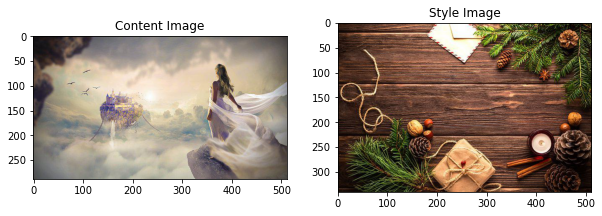

In [5]:
#Next is a small method to display the image.
#We had to write our custom imshow method because, in our load_img method, we are including one more 
#dimension in our input image. Because of this extra dimension, 
#the default imshow function doesn't show this image on the screen.
def imshow(img, title=None):
  # Remove the batch dimension
  out = np.squeeze(img, axis=0)
  # Normalize for display 
  out = out.astype('uint8')
  plt.imshow(out)
  if title is not None:
    plt.title(title)
  plt.imshow(out)
#Now let’s use these defined methods to read and process our images. Use the following code:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

In [7]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
  if len(x.shape) != 3:
    raise ValueError("Invalid input to deprocessing image")
  
  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [12]:
#At this stage, we are ready with the data. 
#Now we will be sending to our neural network. 
#For this project, we will be using Transfer Learning.
#For those who don’t know what Transfer Learning is, 
#Transfer learning is a technique where we use the knowledge learned while solving a problem and apply it to a related 
#but same problem. 
#For example, the knowledge gained in recognizing cars can also be applied to recognize trucks. 
#We have many models which are pre-trained on large image dataset. 
#These models have learnt to extract the features from the image. 
#These learning have been stored in the form of the weights of the model. 
#We will simply use them to extract the style and content of our images.
def load_and_process_img(path_to_img):
  img = load_img(path_to_img)
  #img = tf.keras.applications.vgg19.preprocess_input(img)
  img = tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [15]:
#VGG19 is a State-of-the-art image classifier. 
#As in our case, we don’t want to classify images, so we will not use its final layers.
#Using the following code, you will load the model VGG19.
def get_model():
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs

    return keras.models.Model(vgg.input, model_outputs)

In [18]:
#Now, to see how the layers are named
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1']

#To extract the content and style information of an image, we will use different intermediate layers of the model.
#VGG19 is a convolutional neural network(CNN). 
#We all know that CNN takes the raw image as input pixels and generates an internal representation 
#that converts the raw image pixels into a complex understanding of the features present within the image. 
#Simply speaking, CNN has the ability to extract features from the image pixel values and represent it in a numerical way. 
#As we move deeper into the network these features get more complex and near the final CNN layers, 
#the best feature representation of the image is found. Taking this fact into consideration, 
#we will take a layer from the final block of the model for content extraction as it represents the feature of the image well.

#Execute the following code to do that.

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [19]:
#This method, vgg_layers, Creates a vgg model that returns a list of intermediate output values.

#Once the model is ready we will send the input to the model and get the output.
def get_model():
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs

    return keras.models.Model(vgg.input, model_outputs)

In [22]:
#Now be used to calculate the loss. Let’s see how the loss is defined in NST. 
#The total_loss is divided into three parts:
#1). Content Loss: Calculates the difference between the content (pixel values) of content image and generated image.
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

#2). Style Loss: Calculates the difference between the style of content image and generated image.

#3). Variation Loss: Calculates the variation among the neighbouring pixel values of the generated image.

#So, now to calculate the style loss we use a mathematical method called Gram matrix For time being I will just explain
#how to write logic for a Gram matrix in python.
def gram_matrix(input_tensor):
    # We make the image channels first 
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    """Expects two images of dimension h, w, c"""
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    
    return tf.reduce_mean(tf.square(gram_style - gram_target))

In [24]:
#Here we use tf.GradientTape to compute the gradient. 
#It allows us to take advantage of the automatic differentiation available by tracing operations 
#for computing the gradient later. 
#It records the operations during the forward pass and then is able to compute the gradient 
#of our loss function with respect to our input image for the backwards pass.
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):

    style_weight, content_weight = loss_weights
    

    model_outputs = model(init_image)
    
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
    
    style_score = 0
    content_score = 0


    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
        

    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
    
    style_score *= style_weight
    content_score *= content_weight


    loss = style_score + content_score 
    return loss, style_score, content_score

In [26]:
#We’ll define a little helper function that will load our content and style image,
#feed them forward through our network, 
#which will then output the content and style feature representations from our model.
def get_feature_representations(model, content_path, style_path):
    # Load our images in 
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
    
    # batch compute content and style features
    style_outputs = model(style_image)
    content_outputs = model(content_image)
    
    
    # Get the style and content feature representations from our model  
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

In [27]:
#Now let us compute the gradients.
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = compute_loss(**cfg)
  # Compute gradients wrt input image
  total_loss = all_loss[0]
  return tape.gradient(total_loss, cfg['init_image']), all_loss

In [30]:
def run_style_transfer(content_path, 
                       style_path,
                       num_iterations=1000,
                       content_weight=1e3, 
                       style_weight=1e-2): 
  # We don't need to (or want to) train any layers of our model, so we set their
  # trainable to false. 
  model = get_model() 
  for layer in model.layers:
    layer.trainable = False
  
  # Get the style and content feature representations (from our specified intermediate layers) 
  style_features, content_features = get_feature_representations(model, content_path, style_path)
  gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
  # Set initial image
  init_image = load_and_process_img(content_path)
  init_image = tf.Variable(init_image, dtype=tf.float32)
  # Create our optimizer
  opt = keras.optimizers.Adam(learning_rate=3)

  # For displaying intermediate images 
  iter_count = 1
  
  # Store our best result
  best_loss, best_img = float('inf'), None
  
  # Create a nice config 
  loss_weights = (style_weight, content_weight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }
    
  # For displaying
  num_rows = 2
  num_cols = 5
  display_interval = num_iterations/(num_rows*num_cols)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  imgs = []
  for i in tqdm(range(num_iterations)):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      # Update best loss and best image from total loss. 
      best_loss = loss
      best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
      start_time = time.time()
      
      # Use the .numpy() method to get the concrete numpy array
      plot_img = init_image.numpy()
      plot_img = deprocess_img(plot_img)
      imgs.append(plot_img)
      IPython.display.display_png(Image.fromarray(plot_img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.imshow(plot_img)
  plt.show()
  plt.figure(figsize=(14,4))
  for i,img in enumerate(imgs):
      plt.subplot(num_rows,num_cols,i+1)
      plt.imshow(img)
      plt.xticks([])
      plt.yticks([])
    
      
  return best_img, best_loss 

  0%|          | 0/1000 [00:00<?, ?it/s]

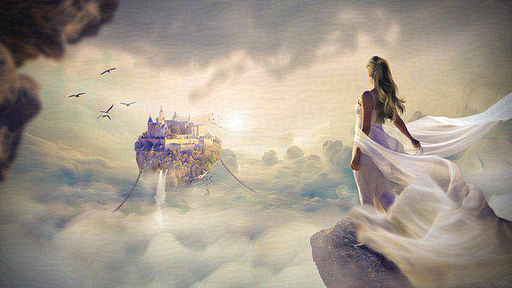

Iteration: 0
Total loss: 6.1753e+08, style loss: 6.1753e+08, content loss: 0.0000e+00, time: 0.2469s


In [ ]:
#now let us run this model on the selected images.
best, best_loss = run_style_transfer(content_path, style_path, num_iterations=1000)